# 5. Wine

* 작성자: 2019920017 김정현

Wine Data를 이용한 분석과 실험이 담긴 Notebook입니다.

각 과정에 대한 자세한 설명은 첨부된 보고서를 참고해주십시오.

## 1. 데이터 분석

In [13]:
%matplotlib inline
import random
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

다음에도 동일한 결과를 얻을 수 있도록 랜덤 시드를 고정한다.

In [14]:
SEED = 1000
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
data = pd.read_csv("./winequality-white.csv", sep=";")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [16]:
data.min()

fixed acidity           3.80000
volatile acidity        0.08000
citric acid             0.00000
residual sugar          0.60000
chlorides               0.00900
free sulfur dioxide     2.00000
total sulfur dioxide    9.00000
density                 0.98711
pH                      2.72000
sulphates               0.22000
alcohol                 8.00000
quality                 3.00000
dtype: float64

In [17]:
data.max()

fixed acidity            14.20000
volatile acidity          1.10000
citric acid               1.66000
residual sugar           65.80000
chlorides                 0.34600
free sulfur dioxide     289.00000
total sulfur dioxide    440.00000
density                   1.03898
pH                        3.82000
sulphates                 1.08000
alcohol                  14.20000
quality                   9.00000
dtype: float64

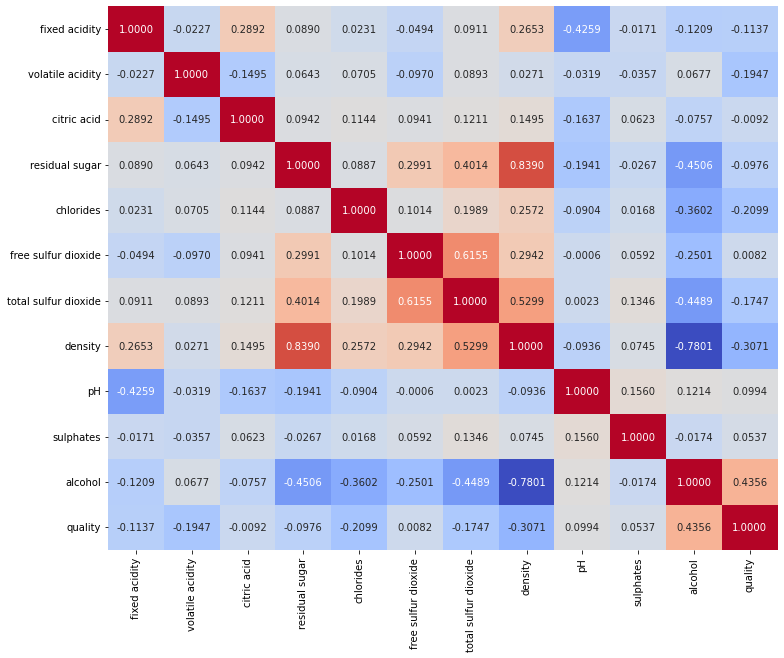

In [18]:
corr_matrix = data.corr(method="pearson")
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".4f",
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
plt.show()

## 2. 모델 학습

앞에서 살펴본 Pearson 상관계수의 값에 따라 총 3가지 모델을 구성하여 학습하였다.

결과적으로, 상관계수와 관계없이 모든 데이터를 활용한 첫번째 모델이 가장 좋은 성능을 냈고, 이는 모델에 적절한 정규화 기법이 적용되었다면 상관계수가 작은 데이터라도 전체 학습에는 도움을 줄 수 있다는 점을 시사한다.

In [19]:
class WineDataset(Dataset):
    inputs: torch.Tensor
    labels: torch.Tensor

    def __init__(self, inputs: np.ndarray, labels: np.ndarray) -> None:
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self) -> int:
        return self.inputs.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, float]:
        return (self.inputs[index], self.labels[index])


class WinePredictor(nn.Module):
    layers: nn.Sequential

    def __init__(self, input_dim: int, quality_count: int) -> None:
        super(WinePredictor, self).__init__()

        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(),

            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, quality_count), # one-hot classifier
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

아래 코드는 제외할 Columns를 입력으로 주면 그에 맞게 학습 데이터를 준비하는 함수이다.

In [20]:
@dataclass
class DataCollection:
    train: WineDataset
    validation: WineDataset
    input_dim: int
    quality_count: int
    min: torch.Tensor
    max: torch.Tensor


def prepare_datasets(path: str, cols_to_drop: List[str] = []) -> DataCollection:
    wineq_pd = pd.read_csv(path, sep=";").drop(cols_to_drop, axis=1)
    wineq_numpy = wineq_pd.to_numpy()
    input_dim = wineq_numpy.shape[1] - 1 # exclude quality
    np.random.shuffle(wineq_numpy)

    # Seperate inputs and labels
    inputs = wineq_numpy[:, :input_dim]
    outputs = wineq_numpy[:, input_dim]

    # Normalize input matrix by column
    min = inputs.min(axis=0, keepdims=1)
    max = inputs.max(axis=0, keepdims=1)
    inputs = (inputs - min) / (max - min)

    # Make worst quality scores to 0
    outputs = outputs - outputs.min()
    
    count = inputs.shape[0]
    return DataCollection(
        WineDataset(inputs[:int(count*0.8)], outputs[:int(count*0.8)]), # Train
        WineDataset(inputs[int(count*0.8):], outputs[int(count*0.8):]), # Validation
        input_dim,
        int(outputs.max())+1,
        min, max
    )

전체 학습 코드는 아래와 같다. 학습에서 제외할 Columns를 인수로 줄 수 있으므로 보고서에서 언급한 3가지 모델을 이 함수 하나만으로도 모두 학습시킬 수 있다.

In [21]:
def train_model(cols_to_drop: List[str]):
    N_EPOCHS = 50
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-2

    datacoll = prepare_datasets("./winequality-white.csv", cols_to_drop)
    train_loader = DataLoader(datacoll.train, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(datacoll.validation, batch_size=64, shuffle=False, num_workers=4)

    model = WinePredictor(datacoll.input_dim, datacoll.quality_count)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    train_loss_hist = []
    val_loss_hist = []

    for epoch in range(1, N_EPOCHS+1):
        model.train()
        train_loss = 0.0
        val_loss = 0.0

        for i, train_pair in enumerate(train_loader, 0):
            x, y = train_pair
            output = model(x)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        
        model.eval()
        total = 0; correct = 0; one_gap = 0
        with torch.no_grad():
            for i, val_pair in enumerate(val_loader, 0):
                x, y = val_pair
                output = model(x)
                predicted = torch.argmax(output, dim=1)
                total += torch.numel(predicted)
                correct += torch.sum(predicted == y)
                one_gap += torch.sum(torch.abs(predicted-y) <= 1)
                loss = criterion(output, y)
                val_loss += loss.item()
        print(", ".join([f"{epoch}:\tTraining: {train_loss/len(train_loader):.5E}",
                f"Validation: {val_loss/len(val_loader):.5E}",
                f"Correct: {correct / total * 100} %",
                f"Diff of 1 or less: {one_gap / total * 100} %"]))
        train_loss_hist.append(train_loss/len(train_loader))
        val_loss_hist.append(val_loss/len(val_loader))
    
    plt.plot(range(0, len(train_loss_hist)), train_loss_hist, "r", label="Training")
    plt.plot(range(0, len(val_loss_hist)), val_loss_hist, "b", label="Validation")
    plt.legend()
    plt.show()

### Model 1

제외하는 데이터 없이 모두 학습시키는 모델. (11차원 입력)

1:	Training: 2.00760E+00, Validation: 1.84768E+00, Correct: 23.469388961791992 %, Diff of 1 or less: 59.79591751098633 %
2:	Training: 1.77790E+00, Validation: 1.68461E+00, Correct: 36.632652282714844 %, Diff of 1 or less: 81.0204086303711 %
3:	Training: 1.59931E+00, Validation: 1.53357E+00, Correct: 45.20408248901367 %, Diff of 1 or less: 90.81632232666016 %
4:	Training: 1.45795E+00, Validation: 1.39115E+00, Correct: 50.306121826171875 %, Diff of 1 or less: 94.28571319580078 %
5:	Training: 1.32695E+00, Validation: 1.28813E+00, Correct: 52.244895935058594 %, Diff of 1 or less: 94.48979187011719 %
6:	Training: 1.22587E+00, Validation: 1.21272E+00, Correct: 53.67346954345703 %, Diff of 1 or less: 94.7959213256836 %
7:	Training: 1.16627E+00, Validation: 1.16635E+00, Correct: 53.26530456542969 %, Diff of 1 or less: 95.40816497802734 %
8:	Training: 1.13175E+00, Validation: 1.14386E+00, Correct: 52.95918655395508 %, Diff of 1 or less: 95.30612182617188 %
9:	Training: 1.11838E+00, Validation: 

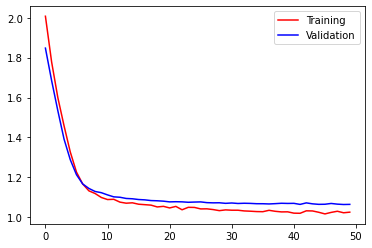

In [22]:
train_model([])

## Model 2

상관계수의 절댓값이 0.1보다 작은 변수들을 제외하여 학습시키는 모델. (8차원 입력)

1:	Training: 2.05354E+00, Validation: 1.94267E+00, Correct: 20.61224365234375 %, Diff of 1 or less: 56.2244873046875 %
2:	Training: 1.86604E+00, Validation: 1.77474E+00, Correct: 29.693878173828125 %, Diff of 1 or less: 70.71427917480469 %
3:	Training: 1.72390E+00, Validation: 1.65386E+00, Correct: 40.51020431518555 %, Diff of 1 or less: 84.28571319580078 %
4:	Training: 1.59045E+00, Validation: 1.52415E+00, Correct: 45.612247467041016 %, Diff of 1 or less: 89.48979187011719 %
5:	Training: 1.45831E+00, Validation: 1.40524E+00, Correct: 49.38775634765625 %, Diff of 1 or less: 92.14285278320312 %
6:	Training: 1.34897E+00, Validation: 1.31967E+00, Correct: 50.204078674316406 %, Diff of 1 or less: 92.14285278320312 %
7:	Training: 1.27067E+00, Validation: 1.26462E+00, Correct: 50.918365478515625 %, Diff of 1 or less: 92.65306091308594 %
8:	Training: 1.22155E+00, Validation: 1.22978E+00, Correct: 51.12245178222656 %, Diff of 1 or less: 93.36734771728516 %
9:	Training: 1.18854E+00, Validation:

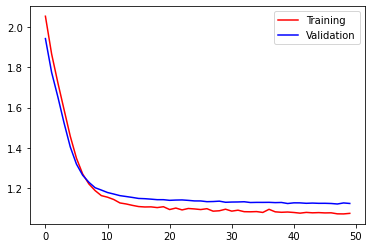

In [23]:
train_model(["citric acid", "residual sugar", "total sulfur dioxide"])

## Model 3

상관계수의 절댓값이 0.2보다 작은 변수들을 제외하여 학습시키는 모델. (3차원 입력)

1:	Training: 2.08331E+00, Validation: 2.02466E+00, Correct: 27.244897842407227 %, Diff of 1 or less: 68.46939086914062 %
2:	Training: 1.92776E+00, Validation: 1.88975E+00, Correct: 29.897958755493164 %, Diff of 1 or less: 73.9795913696289 %
3:	Training: 1.79682E+00, Validation: 1.74687E+00, Correct: 34.28571701049805 %, Diff of 1 or less: 82.7551040649414 %
4:	Training: 1.68755E+00, Validation: 1.65161E+00, Correct: 40.1020393371582 %, Diff of 1 or less: 89.59183502197266 %
5:	Training: 1.58889E+00, Validation: 1.56168E+00, Correct: 43.46938705444336 %, Diff of 1 or less: 91.93877410888672 %
6:	Training: 1.49792E+00, Validation: 1.47110E+00, Correct: 46.224491119384766 %, Diff of 1 or less: 92.65306091308594 %
7:	Training: 1.42262E+00, Validation: 1.39172E+00, Correct: 48.775508880615234 %, Diff of 1 or less: 92.85713958740234 %
8:	Training: 1.36145E+00, Validation: 1.33426E+00, Correct: 48.367347717285156 %, Diff of 1 or less: 92.95918273925781 %
9:	Training: 1.31608E+00, Validation: 

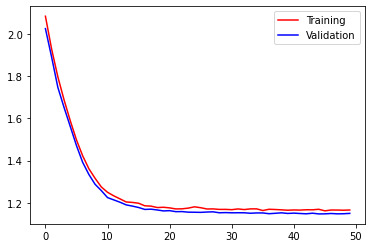

In [24]:
train_model(["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates"])